In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import tqdm
import wandb 

from qumedl.mol.encoding.selfies_ import Selfies
from qumedl.models.transformer.transformer import CausalMolTransformer
from qumedl.models.transformer.loss_functions import compute_transformer_loss
from qumedl.training.collator import TensorBatchCollator
from qumedl.training.tensor_batch import TensorBatch
from qumedl.models.activations import NewGELU
import os
os.environ["CUDA_VISIBLE_DEVICES"]="7"

In [16]:
selfies = Selfies.from_smiles_csv(
    "/root/qcbm/example/data/docking_5_qcbm_6y2f_60_lower_similarity.csv"
    # "/root/qcbm/example/data/full.csv"
)

Loading Selfies From CSV:   0%|          | 0/14599 [00:00<?, ?it/s]

Loading Selfies From CSV: 100%|██████████| 14599/14599 [00:07<00:00, 1899.61it/s]


In [17]:
torch.cuda.is_available()

True

In [26]:
TRAINING_DEVICE = "cuda"

selfies_dataset = selfies.as_dataset()

random_seed = 100
dl_shuffler = torch.Generator()
dl_shuffler.manual_seed(random_seed)

selfies_dl = DataLoader(
    selfies_dataset, 
    batch_size=256, 
    shuffle=True, 
    generator=dl_shuffler,
    collate_fn=TensorBatchCollator()
)

model = CausalMolTransformer(
    vocab_size=selfies.n_tokens,
    embedding_dim=128,
    model_dim=128,
    n_attn_heads=4,
    n_encoder_layers=2,
    hidden_act=NewGELU(),
    dropout=0.1,
    padding_token_idx=selfies.pad_index
)

model.to(TRAINING_DEVICE);

optimizer = torch.optim.AdamW(model.parameters())

In [27]:
selfies.pad_token, selfies.pad_index, selfies.start_token, selfies.start_index,selfies.n_tokens

('[nop]', 4, '[^]', 8, 31)

In [28]:
batch = next(iter(selfies_dl))

batch.inputs, batch.targets_or_labels

(tensor([[ 8, 23, 23,  ...,  4,  4,  4],
         [ 8, 23, 23,  ...,  4,  4,  4],
         [ 8, 23, 23,  ...,  4,  4,  4],
         ...,
         [ 8, 23, 23,  ...,  4,  4,  4],
         [ 8, 23, 23,  ...,  4,  4,  4],
         [ 8, 23, 23,  ...,  4,  4,  4]], dtype=torch.int32),
 tensor([[ 8, 23, 23,  ...,  4,  4,  4],
         [ 8, 23, 23,  ...,  4,  4,  4],
         [ 8, 23, 23,  ...,  4,  4,  4],
         ...,
         [ 8, 23, 23,  ...,  4,  4,  4],
         [ 8, 23, 23,  ...,  4,  4,  4],
         [ 8, 23, 23,  ...,  4,  4,  4]], dtype=torch.int32))

In [35]:
n_epochs = 100
gradient_accumulation_steps = 1

In [36]:
for epoch in range(n_epochs):
    with tqdm.tqdm(total=len(selfies_dl)) as prog_bar:
        tensor_batch: TensorBatch
        for step, tensor_batch in enumerate(selfies_dl):
            tensor_batch.to(TRAINING_DEVICE)
            total_loss = compute_transformer_loss(model, tensor_batch)
            
            total_loss.backward()
        
            if step % gradient_accumulation_steps == 0:
                optimizer.step()
                optimizer.zero_grad()
            
            step_losses = {"total_loss": total_loss.item()}
        
            prog_bar.set_postfix(step_losses)
            prog_bar.update()
            
            if wandb.run is not None:
                wandb.log(step_losses)
            
            tensor_batch.to("cpu")

100%|██████████| 58/58 [00:06<00:00,  8.82it/s, total_loss=0.0607]


In [37]:
start_tokens = torch.full((100, 1), fill_value=selfies.start_index, device=TRAINING_DEVICE, dtype=torch.int)
generated = model.generate(start_tokens, max_new_tokens=selfies.max_length)

new_mol = selfies.decode(generated.cpu().numpy())

In [38]:
smi = selfies.selfie_to_smiles(new_mol)

In [43]:
from rdkit.Chem import Draw
from rdkit import Chem
import numpy as np

In [48]:
rng = np.random.default_rng()
selected_smiles = rng.choice(smi, 100, replace=False)
mols = [Chem.MolFromSmiles(smile_) for smile_ in selected_smiles]
img = Draw.MolsToGridImage(mols, molsPerRow=20, returnPNG=False)
# log_t0_wandb.update({"dicovery": wandb.Image(img)})
img.save(f"epoch_{epoch}_128_1.png")

/opt/conda/lib/python3.10/site-packages/rdkit/Chem/Draw/IPythonConsole.py:261: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


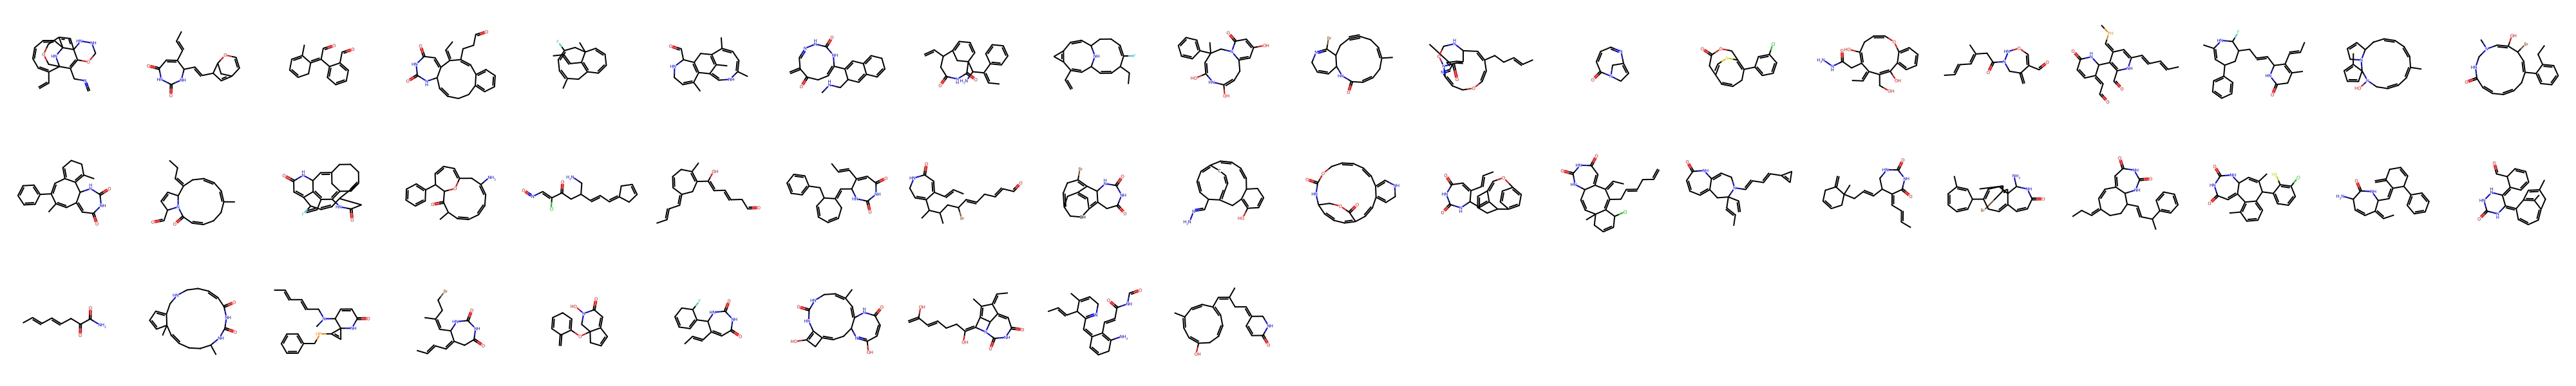

In [49]:
img